In [80]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA # Импорт ARIMA
import matplotlib.pyplot as plt
import warnings

# Игнорировать предупреждения, которые могут возникать при подборе ARIMA
warnings.filterwarnings("ignore")
import os
data_dir = 'data'

In [81]:
# Укажите путь к вашему файлу Excel
file_path = os.path.join(r'data', r'FillipsCurve.xlsx')

# Загрузка данных
try:
    data = pd.read_excel(file_path, index_col='Data', parse_dates=True)
except FileNotFoundError:
    print(f"Ошибка: Файл '{file_path}' не найден. Пожалуйста, убедитесь, что файл находится в правильной директории.")
    exit()
    
# Переименование колонок для удобства, используя предоставленные названия
data = data.rename(columns={
    'Core inf': 'inflation',
    'M1': 'M1',
    'Wages': 'Wage', # Используем 'Wage' как в формуле задачи
    'Imp prices': 'ImPrices', # Используем 'ImPrices' как в формуле задачи
    'Unemployment': 'unemployment'
    # 'Exp prices' не используется в формуле модифицированной кривой Филлипса в задаче
})

# Переименуем индекс для ясности, если он называется 'Data'
if data.index.name == 'Data':
    data.index.name = 'Date'

# (а) Ограничение выборки с июля 2009 г.

In [82]:
start_date = '2009-07-01'
data_filtered = data[data.index >= start_date].copy()

Проверка стационарности рядов инфляции и безработицы (ADF тест)
Используем 6 лагов

In [83]:
# Инфляция
inflation_series = data_filtered['inflation'].dropna()
d_inflation = 0 # Порядок интегрирования для инфляции
if not inflation_series.empty:
    adf_inflation = adfuller(inflation_series, maxlag=6, autolag=None)
    print(f'ADF тест для инфляции:')
    print(f'  ADF Statistic: {adf_inflation[0]}')
    print(f'  p-value: {adf_inflation[1]}')
    print('  Критические значения:')
    for key, value in adf_inflation[4].items():
        print(f'    {key}: {value}')
    if adf_inflation[1] > 0.05:
        print("  Ряд инфляции нестационарен. Применим дифференцирование.")
        data_filtered['inflation_diff'] = data_filtered['inflation'].diff().dropna()
        inflation_series_diff = data_filtered['inflation_diff'].dropna()
        if not inflation_series_diff.empty:
            adf_inflation_diff = adfuller(inflation_series_diff, maxlag=6, autolag=None)
            print(f'  ADF тест для разности инфляции:')
            print(f'    ADF Statistic: {adf_inflation_diff[0]}')
            print(f'    p-value: {adf_inflation_diff[1]}')
            if adf_inflation_diff[1] <= 0.05:
                print("  Ряд разности инфляции стационарен.")
                d_inflation = 1 # Устанавливаем порядок интегрирования в 1
            else:
                 print("  Ряд разности инфляции все еще нестационарен.")
                 print("  Внимание: Ряд инфляции требует более высокого порядка интегрирования или другой обработки.")
        else:
            print("  Недостаточно данных после дифференцирования для теста разности инфляции.")
    else:
        print("  Ряд инфляции стационарен.")
else:
    print("  Ряд инфляции пуст после фильтрации.")


# Безработица
unemployment_series = data_filtered['unemployment'].dropna()
d_unemployment = 0 # Порядок интегрирования для безработицы
if not unemployment_series.empty:
    adf_unemployment = adfuller(unemployment_series, maxlag=6, autolag=None)
    print(f'\n\nADF тест для безработицы:')
    print(f'  ADF Statistic: {adf_unemployment[0]}')
    print(f'  p-value: {adf_unemployment[1]}')
    print('  Критические значения:')
    for key, value in adf_unemployment[4].items():
        print(f'    {key}: {value}')
    if adf_unemployment[1] > 0.05:
        print("  Ряд безработицы нестационарен. Применим дифференцирование.")
        data_filtered['unemployment_diff'] = data_filtered['unemployment'].diff().dropna()
        unemployment_series_diff = data_filtered['unemployment_diff'].dropna()
        if not unemployment_series_diff.empty:
            adf_unemployment_diff = adfuller(unemployment_series_diff, maxlag=6, autolag=None)
            print(f'  ADF тест для разности безработицы:')
            print(f'    ADF Statistic: {adf_unemployment_diff[0]}')
            print(f'    p-value: {adf_unemployment_diff[1]}')
            if adf_unemployment_diff[1] <= 0.05:
                print("  Ряд разности безработицы стационарен.")
                d_unemployment = 1 # Устанавливаем порядок интегрирования в 1
            else:
                print("  Ряд разности безработицы все еще нестационарен.")
                print("  Внимание: Ряд безработицы требует более высокого порядка интегрирования или другой обработки.")
        else:
             print("  Недостаточно данных после дифференцирования для теста разности безработицы.")
    else:
        print("  Ряд безработицы стационарен.")
else:
     print("  Ряд безработицы пуст после фильтрации.")

ADF тест для инфляции:
  ADF Statistic: -2.1811151605218955
  p-value: 0.21317081651540953
  Критические значения:
    1%: -3.5714715250448363
    5%: -2.922629480573571
    10%: -2.5993358475635153
  Ряд инфляции нестационарен. Применим дифференцирование.
  ADF тест для разности инфляции:
    ADF Statistic: -1.9412979782914224
    p-value: 0.3128894485860979
  Ряд разности инфляции все еще нестационарен.
  Внимание: Ряд инфляции требует более высокого порядка интегрирования или другой обработки.


ADF тест для безработицы:
  ADF Statistic: 1.2913455201079649
  p-value: 0.9965600366047301
  Критические значения:
    1%: -3.5714715250448363
    5%: -2.922629480573571
    10%: -2.5993358475635153
  Ряд безработицы нестационарен. Применим дифференцирование.
  ADF тест для разности безработицы:
    ADF Statistic: -3.7547589834664263
    p-value: 0.0034056284994737323
  Ряд разности безработицы стационарен.


# (б) Тест причинности по Грейнджеру между инфляцией и безработицей
Используем 12 лагов


Для теста Грейнджера ряды должны быть стационарными.<br>
Используем либо исходные ряды, если они стационарны, либо их разности.<br>
Определяем ряды для теста Грейнджера на основе порядка интегрирования <br>

In [84]:
granger_inflation_series = data_filtered['inflation'].diff(d_inflation).dropna() if d_inflation > 0 else data_filtered['inflation'].dropna()
granger_unemployment_series = data_filtered['unemployment'].diff(d_unemployment).dropna() if d_unemployment > 0 else data_filtered['unemployment'].dropna()

Объединяем ряды в один DataFrame для теста Грейнджера

In [85]:
granger_data = pd.DataFrame({
    'inflation': granger_inflation_series,
    'unemployment': granger_unemployment_series
}).dropna()

In [86]:
if not granger_data.empty:
    # Проверяем причинность: безработица -> инфляция
    print("\nПроверка: безработица Грейнджер-причиняет инфляцию?")
    try:
        # Убедимся, что данных достаточно для 12 лагов
        if len(granger_data) > 12:
            gc_unemployment_to_inflation = grangercausalitytests(granger_data[['inflation', 'unemployment']], maxlag=12, verbose=False)
            # Выводим p-значения для каждого лага
            for lag in range(1, 13):
                 if lag in gc_unemployment_to_inflation:
                     p_value = gc_unemployment_to_inflation[lag][0]['ssr_ftest'][1]
                     print(f"  Лаг {lag}: p-value = {p_value:.4f}")
                     if p_value <= 0.05:
                         print(f"    На лаге {lag} есть свидетельства причинности.")
                 else:
                     print(f"  Недостаточно данных для теста Грейнджера на лаге {lag}.")
        else:
             print("  Недостаточно данных для выполнения теста Грейнджера с 12 лагами.")

    except Exception as e:
        print(f"  Не удалось выполнить тест Грейнджера для безработицы -> инфляция: {e}")
        print("  Убедитесь, что ряды достаточно длинные для 12 лагов после обработки пропущенных значений.")


    # Проверяем причинность: инфляция -> безработица
    print("\nПроверка: инфляция Грейнджер-причиняет безработицу?")
    try:
        # Убедимся, что данных достаточно для 12 лагов
        if len(granger_data) > 12:
            gc_inflation_to_unemployment = grangercausalitytests(granger_data[['unemployment', 'inflation']], maxlag=12, verbose=False)
            # Выводим p-значения для каждого лага
            for lag in range(1, 13):
                if lag in gc_inflation_to_unemployment:
                    p_value = gc_inflation_to_unemployment[lag][0]['ssr_ftest'][1]
                    print(f"  Лаг {lag}: p-value = {p_value:.4f}")
                    if p_value <= 0.05:
                         print(f"    На лаге {lag} есть свидетельства причинности.")
                else:
                     print(f"  Недостаточно данных для теста Грейнджера на лаге {lag}.")
        else:
             print("  Недостаточно данных для выполнения теста Грейнджера с 12 лагами.")

    except Exception as e:
        print(f"  Не удалось выполнить тест Грейнджера для инфляции -> безработица: {e}")
        print("  Убедитесь, что ряды достаточно длинные для 12 лагов после обработки пропущенных значений.")

else:
    print("  Недостаточно данных для теста Грейнджера после обработки пропущенных значений.")


Проверка: безработица Грейнджер-причиняет инфляцию?
  Лаг 1: p-value = 0.9407
  Лаг 2: p-value = 0.7998
  Лаг 3: p-value = 0.9059
  Лаг 4: p-value = 0.9049
  Лаг 5: p-value = 0.4467
  Лаг 6: p-value = 0.7065
  Лаг 7: p-value = 0.8908
  Лаг 8: p-value = 0.9848
  Лаг 9: p-value = 0.8428
  Лаг 10: p-value = 0.7716
  Лаг 11: p-value = 0.6438
  Лаг 12: p-value = 0.1827

Проверка: инфляция Грейнджер-причиняет безработицу?
  Лаг 1: p-value = 0.6517
  Лаг 2: p-value = 0.3463
  Лаг 3: p-value = 0.1270
  Лаг 4: p-value = 0.1129
  Лаг 5: p-value = 0.2032
  Лаг 6: p-value = 0.0243
    На лаге 6 есть свидетельства причинности.
  Лаг 7: p-value = 0.1090
  Лаг 8: p-value = 0.2077
  Лаг 9: p-value = 0.3660
  Лаг 10: p-value = 0.5047
  Лаг 11: p-value = 0.7115
  Лаг 12: p-value = 0.8384


# (в) Подбор ARIMA модели для ожидаемой инфляции ($\pi_{t}^{e}$)
Предполагаем, что ожидаемая инфляция описывается ARIMA моделью для $\pi_t$.
Подберем порядок (p, d, q) ARIMA модели с использованием информационных критериев (например, AIC).

In [87]:
print("\nПодбор ARIMA модели для инфляции для оценки ожидаемой инфляции:")

# Используем исходный ряд инфляции для подбора ARIMA, т.к. ARIMA включает дифференцирование (параметр d)
arima_inflation_series = data_filtered['inflation'].dropna()

if not arima_inflation_series.empty:
    best_aic = np.inf
    best_order = None

    # Определяем максимальные порядки для p и q для поиска
    max_p = 5 # Можно настроить
    max_q = 5 # Можно настроить

    # Порядок интегрирования (d) определен из ADF теста
    order_d = d_inflation
    print(f"Порядок интегрирования (d) для ARIMA модели инфляции: {order_d}")

    # Поиск лучшей комбинации (p, q)
    print(f"Поиск лучшего порядка (p, {order_d}, q) для ARIMA модели (p от 0 до {max_p}, q от 0 до {max_q})...")
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            if p == 0 and q == 0:
                continue # Модель (0, d, 0) - это просто случайное блуждание или белый шум, если d=0
            order = (p, order_d, q)
            try:
                model = ARIMA(arima_inflation_series, order=order)
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = order
                # print(f'ARIMA{order} AIC={results.aic}') # Отладочный вывод
            except Exception as e:
                # print(f"Не удалось подогнать ARIMA{order} модель: {e}") # Отладочный вывод
                continue # Пропускаем комбинации, которые не удается подогнать

    if best_order is not None:
        print(f"Лучший порядок ARIMA модели для инфляции по AIC: {best_order}")

        # Оцениваем ARIMA модель с лучшим порядком
        arima_model = ARIMA(arima_inflation_series, order=best_order)
        arima_results = arima_model.fit()
        print(arima_results.summary())

        # Ожидаемая инфляция ($\pi_{t}^{e}$) - это прогнозируемые значения из ARIMA модели
        # Прогнозы ARIMA начинаются с первого наблюдения, но для кривой Филлипса нужен лаг t-1
        # Поэтому прогнозируем на один шаг вперед для каждого момента времени
        # Используем predict() для получения прогнозов на тот же период, что и исходные данные
        # Прогнозы будут доступны с момента времени, достаточного для учета лагов (p и q)
        # Для получения прогнозов для t, модель должна быть обучена на данных до t-1.
        # Простой способ - использовать fittedvalues, которые являются прогнозами на один шаг вперед
        # на основе данных до текущего момента времени.
        expected_inflation_fitted = arima_results.fittedvalues

        # Создаем серию ожидаемой инфляции с индексом исходных данных
        expected_inflation = pd.Series(np.nan, index=data_filtered.index)
        # fittedvalues имеют тот же индекс, что и arima_inflation_series, но могут начинаться позже
        expected_inflation.loc[expected_inflation_fitted.index] = expected_inflation_fitted.values

        data_filtered['expected_inflation'] = expected_inflation

    else:
        print("Не удалось подобрать подходящий порядок ARIMA модели для инфляции.")
        data_filtered['expected_inflation'] = np.nan # Добавляем столбец с NaN, если модель не подобрана
else:
    print("  Ряд инфляции пуст для подбора ARIMA модели.")
    data_filtered['expected_inflation'] = np.nan # Добавляем столбец с NaN, если ряд пуст


Подбор ARIMA модели для инфляции для оценки ожидаемой инфляции:
Порядок интегрирования (d) для ARIMA модели инфляции: 0
Поиск лучшего порядка (p, 0, q) для ARIMA модели (p от 0 до 5, q от 0 до 5)...
Лучший порядок ARIMA модели для инфляции по AIC: (4, 0, 2)
                               SARIMAX Results                                
Dep. Variable:              inflation   No. Observations:                   56
Model:                 ARIMA(4, 0, 2)   Log Likelihood                  53.438
Date:                Sun, 27 Apr 2025   AIC                            -90.875
Time:                        13:55:09   BIC                            -74.673
Sample:                             0   HQIC                           -84.594
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

# (г) Оценка модифицированной кривой Филлипса
$\pi_{t}=const+\phi(u_{t-1}-u^{f})+\alpha m_{t-1}+\beta w_{t-1}+\gamma ImPrice_{t-1}+\pi_{t}^{e}+\epsilon_{t}$

Для оценки требуется естественный уровень безработицы ($u^f$).<br>
В задаче не указано, как его получить.<br>
Возможные варианты: использовать среднее значение фактической безработицы за период,<br>
или использовать данные из внешних источников.<br>
В этом примере для простоты примем $u^f$ как среднее значение фактической безработицы за рассматриваемый период.<br>
В реальном исследовании следует использовать более обоснованный подход.<br>

In [88]:
uf = data_filtered['unemployment'].mean()
print(f"\nПринимаем естественный уровень безработицы (uf) как среднее значение фактической безработицы: {uf:.2f}")


Принимаем естественный уровень безработицы (uf) как среднее значение фактической безработицы: 8.58


Создание переменных для регрессии
Приросты денежной массы, зарплаты, цен на импорт

In [89]:
data_filtered['m'] = data_filtered['M1'].pct_change()
data_filtered['w'] = data_filtered['Wage'].pct_change()
data_filtered['ImPrice'] = data_filtered['ImPrices'].pct_change()

Лаги переменных<br>

In [90]:
data_filtered['unemployment_lag1'] = data_filtered['unemployment'].shift(1)
data_filtered['m_lag1'] = data_filtered['m'].shift(1)
data_filtered['w_lag1'] = data_filtered['w'].shift(1)
data_filtered['ImPrice_lag1'] = data_filtered['ImPrice'].shift(1)

Отклонение безработицы от естественного уровня с лагом<br>

In [91]:
data_filtered['unemployment_gap_lag1'] = data_filtered['unemployment_lag1'] - uf

Целевая переменная: инфляция ($\pi_t$)<br>
Используем исходный ряд инфляции, так как ожидаемая инфляция из ARIMA уже учитывает стационарность<br>

In [92]:
regression_inflation = data_filtered['inflation']

Предикторы<br>
Используем ожидаемую инфляцию, полученную из ARIMA модели<br>
Убедимся, что ожидаемая инфляция выровнена по времени с целевой переменной<br>
regression_data будет содержать только те строки, где есть все необходимые данные<br>

In [93]:
regression_data = pd.DataFrame({
    'inflation': regression_inflation,
    'unemployment_gap_lag1': data_filtered['unemployment_gap_lag1'],
    'm_lag1': data_filtered['m_lag1'],
    'w_lag1': data_filtered['w_lag1'],
    'ImPrice_lag1': data_filtered['ImPrice_lag1'],
    'expected_inflation': data_filtered['expected_inflation']
}).dropna() # Удаляем строки с пропущенными значениями

Добавляем константу для регрессии

In [94]:
X = sm.add_constant(regression_data[['unemployment_gap_lag1', 'm_lag1', 'w_lag1', 'ImPrice_lag1', 'expected_inflation']])
y = regression_data['inflation']


Результаты оценки модифицированной кривой Филлипса:
                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     250.9
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           3.56e-33
Time:                        13:55:09   Log-Likelihood:                 53.633
No. Observations:                  54   AIC:                            -95.27
Df Residuals:                      48   BIC:                            -83.33
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

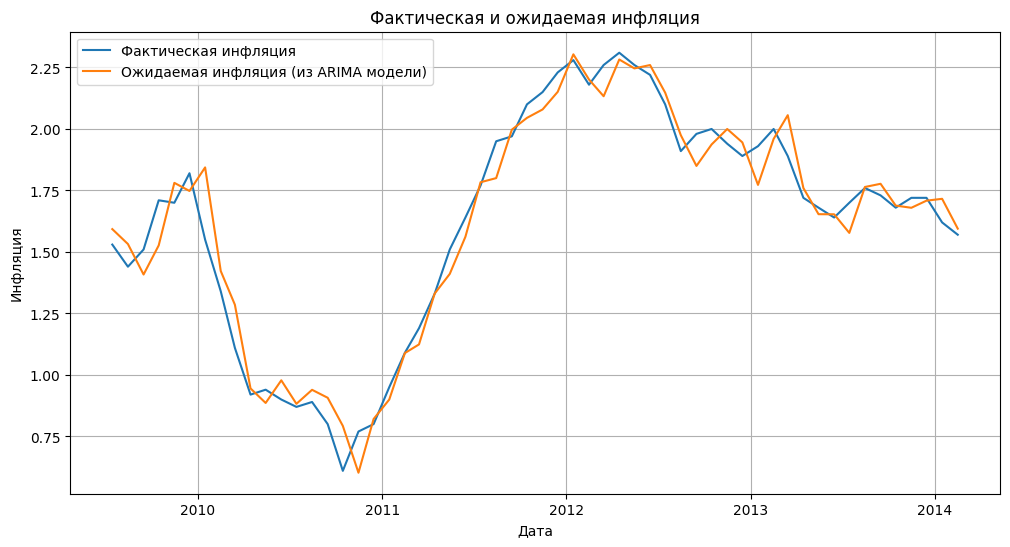

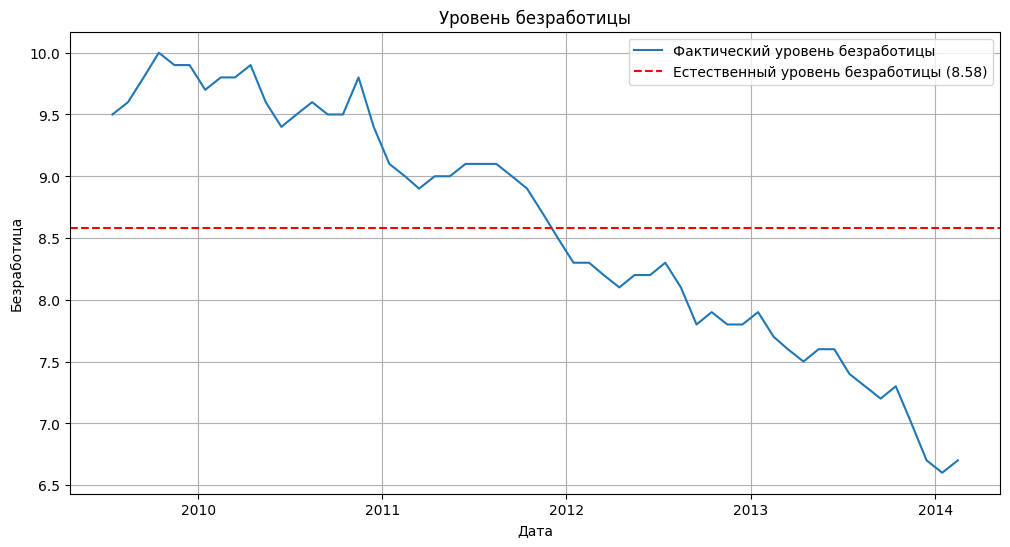

In [ ]:
if not regression_data.empty:
    # Оценка модели методом OLS
    try:
        model_phillips = sm.OLS(y, X)
        results_phillips = model_phillips.fit()

        # Вывод результатов регрессии
        print("\nРезультаты оценки модифицированной кривой Филлипса:")
        print(results_phillips.summary())

        # Интерпретация результатов и проверка качества модели
        print("\nИнтерпретация результатов:")
        print("- Коэффициент при 'unemployment_gap_lag1' (phi) показывает влияние отклонения безработицы от естественного уровня на инфляцию.")
        print("- Коэффициенты при 'm_lag1', 'w_lag1', 'ImPrice_lag1' показывают влияние лагированных приростов денежной массы, зарплаты и цен на импорт.")
        print("- Коэффициент при 'expected_inflation' показывает влияние ожидаемой инфляции.")
        print("\nПроверка качества модели:")
        print(f"- R-squared: {results_phillips.rsquared:.4f} (Доля дисперсии инфляции, объясняемая моделью)")
        print("- Adj. R-squared: Учитывает количество предикторов.")
        print("- Значимость коэффициентов (p-values): Если p-value < 0.05, коэффициент статистически значим на 5% уровне.")
        print("- F-statistic и его p-value: Проверяет общую значимость регрессии.")

    except Exception as e:
        print(f"Не удалось оценить модель кривой Филлипса: {e}")
        print("Убедитесь, что после обработки пропущенных значений осталось достаточно данных для регрессии.")

else:
    print("\nНедостаточно данных для оценки модели кривой Филлипса после обработки пропущенных значений.")

# Визуализация (опционально)
# Можно построить графики рядов, остатков модели и т.д.
# Например, график фактической и ожидаемой инфляции
if 'expected_inflation' in data_filtered.columns and not data_filtered[['inflation', 'expected_inflation']].dropna().empty:
    plt.figure(figsize=(12, 6))
    plt.plot(data_filtered['inflation'].dropna().index, data_filtered['inflation'].dropna(), label='Фактическая инфляция')
    # Ожидаемая инфляция из ARIMA может начинаться позже из-за лагов
    plt.plot(data_filtered['expected_inflation'].dropna().index, data_filtered['expected_inflation'].dropna(), label='Ожидаемая инфляция (из ARIMA модели)')
    plt.title('Фактическая и ожидаемая инфляция')
    plt.xlabel('Дата')
    plt.ylabel('Инфляция')
    plt.legend()
    plt.grid(True)
    plt.show()

# График фактической безработицы
if not data_filtered['unemployment'].dropna().empty:
    plt.figure(figsize=(12, 6))
    plt.plot(data_filtered['unemployment'].dropna().index, data_filtered['unemployment'].dropna(), label='Фактический уровень безработицы')
    plt.axhline(y=uf, color='r', linestyle='--', label=f'Естественный уровень безработицы ({uf:.2f})')
    plt.title('Уровень безработицы')
    plt.xlabel('Дата')
    plt.ylabel('Безработица')
    plt.legend()
    plt.grid(True)
    plt.show()